In [1]:
# import the necessary packages
from unet.dataset import SegmentationDataset
from unet.model import UNet
from unet import config
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms, utils
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os

In [2]:
config.DEVICE

'cuda'

In [11]:
# Create dirs if they don't exist
DIRS = [config.BASE_OUTPUT, config.MODEL_PATH, config.TENSORBOARD_PATH]

for d in DIRS:
    if not os.path.exists(d):
        os.makedirs(d)

In [3]:
# load the image and mask filepaths in a sorted manner
image_paths = list(paths.list_images(config.IMAGE_DATASET_PATH))
original_mask_paths = list(paths.list_images(config.MASK_DATASET_PATH))
mask_paths = []
# iterate over image paths "composite/<X>-<Y>.png" and find the mating mask path "obstacle/<Y>.png"
for imagePath in image_paths:
    # extract the filename and extension
    filename = os.path.basename(imagePath)
    # extract the base name <Y> of the image path <X>-<Y>.png
    baseName = filename.split("-")[1]
    # construct the expected mask path "obstacle/<Y>.png"
    expected_mask_path = os.path.join(config.MASK_DATASET_PATH, baseName)
    # check if the expected mask path exists
    if expected_mask_path in original_mask_paths:
        # if it exists, append the mask path to the list
        mask_paths.append(expected_mask_path)
    else:
        # if it does not exist, print a warning message
        print(
            f"[WARNING] expected mask path {expected_mask_path} does not exist for image {imagePath}"
        )

In [4]:
image_paths[42], mask_paths[42]

('../dataset/composite/2-11790.png', '../dataset/obstacle/11790.png')

In [5]:
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(
    image_paths, mask_paths, test_size=config.TEST_SPLIT, random_state=42
)
# unpack the data split
(training_images, validation_images) = split[:2]
(training_masks, validation_masks) = split[2:]

In [6]:
# define transformations
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDTH)),
        transforms.ToTensor(),
    ]
)
# create the train and test datasets
training_set = SegmentationDataset(
    image_paths=training_images, mask_paths=training_masks, transforms=transform
)
validation_set = SegmentationDataset(
    image_paths=validation_images, mask_paths=validation_masks, transforms=transform
)
print(f"[INFO] found {len(training_set)} examples in the training set...")
print(f"[INFO] found {len(validation_set)} examples in the validation set...")
# create the training and test data loaders
training_loader = DataLoader(
    training_set,
    shuffle=True,
    batch_size=config.BATCH_SIZE,
    pin_memory=config.PIN_MEMORY
)
validation_loader = DataLoader(
    validation_set,
    shuffle=False,
    batch_size=config.BATCH_SIZE,
    pin_memory=config.PIN_MEMORY
)

[INFO] found 735 examples in the training set...
[INFO] found 82 examples in the validation set...


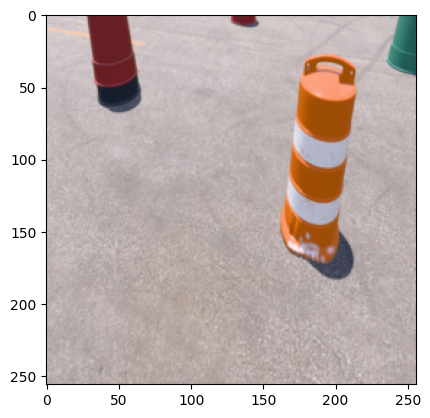

In [6]:
plt.imshow(training_loader.dataset[0][0].permute(1, 2, 0))

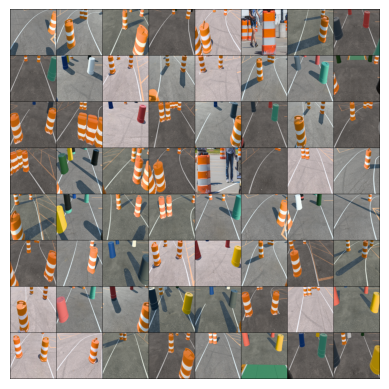

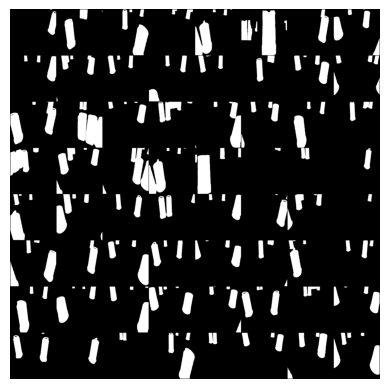

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img):
    plt.imshow(img.permute(1, 2, 0))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = utils.make_grid(images)
mask_grid = utils.make_grid(labels)
matplotlib_imshow(img_grid)
plt.axis("off")
plt.show()
matplotlib_imshow(mask_grid)
plt.axis("off")
plt.show()

In [7]:
model = UNet().to(config.DEVICE)

loss_fn = BCEWithLogitsLoss()

optimizer = Adam(model.parameters(), lr=config.INIT_LR)

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = inputs.to(config.DEVICE)
        labels = labels.to(config.DEVICE)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [ ]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(config.TENSORBOARD_PATH, os.path.join('igvc_unet_trainer_{}'.format(timestamp)))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    i = 0

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(config.DEVICE)
            vlabels = vlabels.to(config.DEVICE)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = os.path.join(config.MODEL_PATH, 'model_{}_{}.pth'.format(timestamp, epoch_number))
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

# Close the writer when done
writer.close()

EPOCH 1:
LOSS train 0.0 valid 0.382587194442749
EPOCH 2:
LOSS train 0.0 valid 0.3086233139038086
EPOCH 3:
LOSS train 0.0 valid 0.26769211888313293
EPOCH 4:


KeyboardInterrupt: 